<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/single_cell_g_umap_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### [Computational challenges of cell cycle analysis using single cell transcriptomics](https://arxiv.org/pdf/2208.05229.pdf)

In [ ]:
# !pip install squarify
!pip install scanpy
# !git clone https://github.com/dcolinmorgan/cuCat.git
# !git clone https://github.com/graphistry/pygraphistry.git
# !git clone https://github.com/dirty-cat/dirty_cat.git

import scanpy as sc
import anndata

In [ ]:
# !pip install graphistry
import graphistry

graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='f5UwthGEF@F@xnP')
graphistry.__version__


'0.28.7'

In [ ]:
#download 5 single cell datasets
%%bash
wget https://www.dropbox.com/s/xza477kxj7vgdlr/GSE67123_6.h5ad.zip
wget https://www.dropbox.com/s/9r2f3bz4jss9vvr/GSE74767_2.h5ad.zip
wget https://www.dropbox.com/s/thhiv9va2415x6d/GSE97391_27.h5ad.zip
wget https://www.dropbox.com/s/sl76p7hydt40wnv/GSE98664_20.h5ad.zip
wget https://www.dropbox.com/s/i7lyxxa9td2gpmv/GSE97391_22.h5ad.zip
unzip GSE67123_6.h5ad.zip
unzip GSE74767_2.h5ad.zip
unzip GSE97391_27.h5ad.zip
unzip GSE98664_20.h5ad.zip
unzip GSE97391_22.h5ad.zip

In [ ]:
!mkdir single_cell
!mv *.h5ad single_cell

In [ ]:
import os, time
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pstats import Stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)

# import dirty_cat
# from dirty_cat import GapEncoder as dc_ge
# from dirty_cat import SuperVectorizer as dc_sv

# print(dirty_cat.__file__)

# import cuCat

# from cuCat import GapEncoder as cc_gap 
# from cuCat import SuperVectorizer as cc_sv

# print(cuCat.__file__)

### dataset descriptions (last one is largest)

In [ ]:

list_files = []
for dirname, _, filenames in os.walk('single_cell'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_files.append(os.path.join(dirname, filename))
        


for fn in list_files:
    adata = sc.read(fn) # sc.read_h5ad
    print( adata.uns['info'] )
    print()

['mESC in vitro (RamDA-seq)' 'Validation' '456' 'nan' 'nan' '456' '47515'
 '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'RamDA-seq' 'Timepoints'
 'in vitro' '29434199' '20180212' 'GSE98664' 'Nature Communications' 'nan']

['Blastocyst timepoints (SC3-seq)' 'Validation' '421' 'nan' 'nan' '421'
 '28796' '13' '13' 'TPM/FPKM' 'Macaque' '1' 'Embryo' 'SC3-seq'
 'Timepoints' 'in vivo' '27556940' '20160901' 'GSE74767' 'Nature' 'nan']

['Standard in vitro neuron (inDrop)' 'Validation' '2996' 'nan' 'nan'
 '2411' '28205' '7' '7' 'UMI' 'Mouse' '1' 'Brain' 'inDrop' 'Phenotypes'
 'in vitro' '28990928' '20171009' 'GSE97391' 'Elife'
 'Cell types involved in neuronal differentiation as highlighted with dashed boundaries in Figure 2 of the original study were assigned ranks based on known differentiation status. ']

['Embryonic HSCs (Tang et al.)' 'Validation' '143' 'nan' 'nan' '143'
 '24028' '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'Tang et al.'
 'Timepoints' 'in vivo' '27225119' '20160526' 'GSE67123' 'Natur

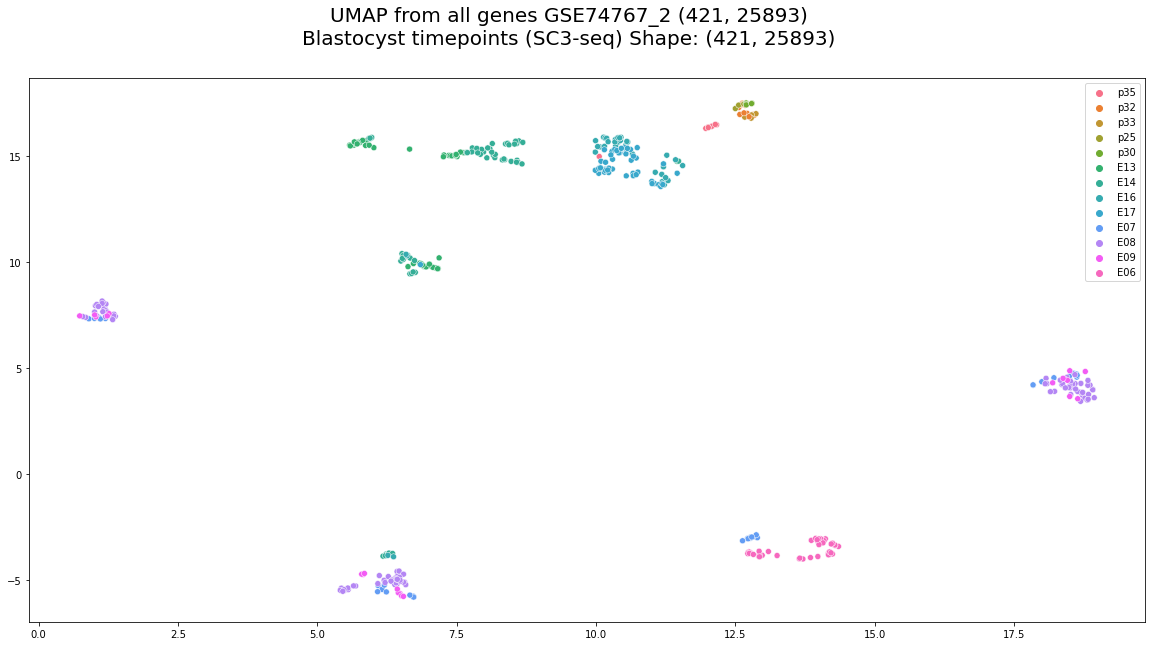

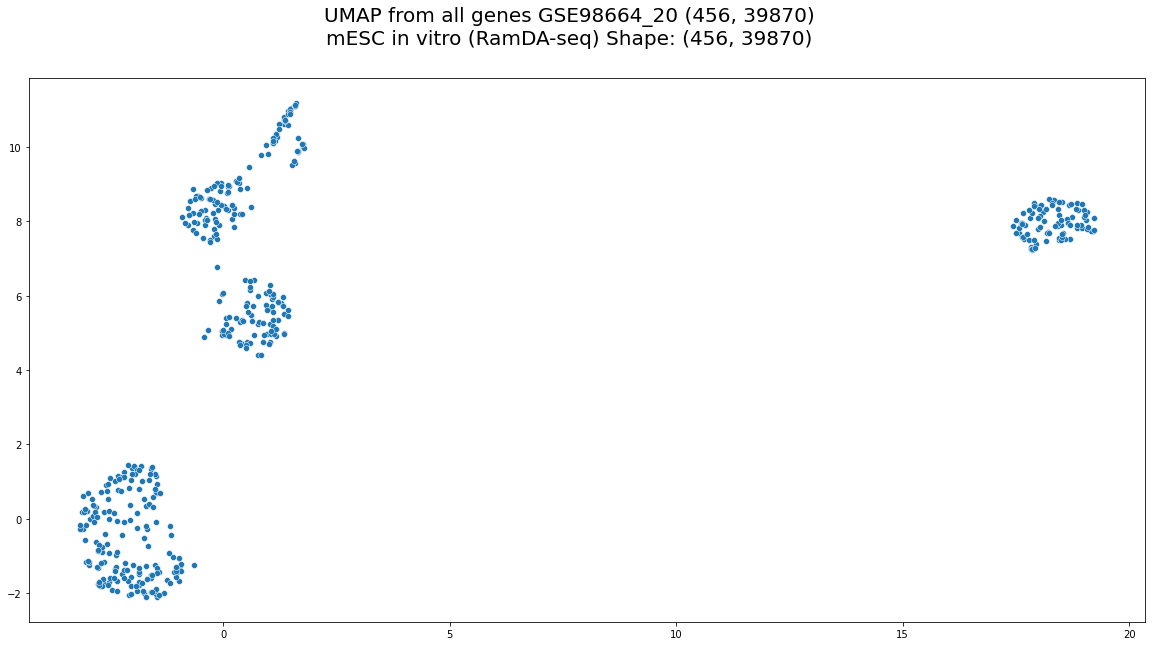

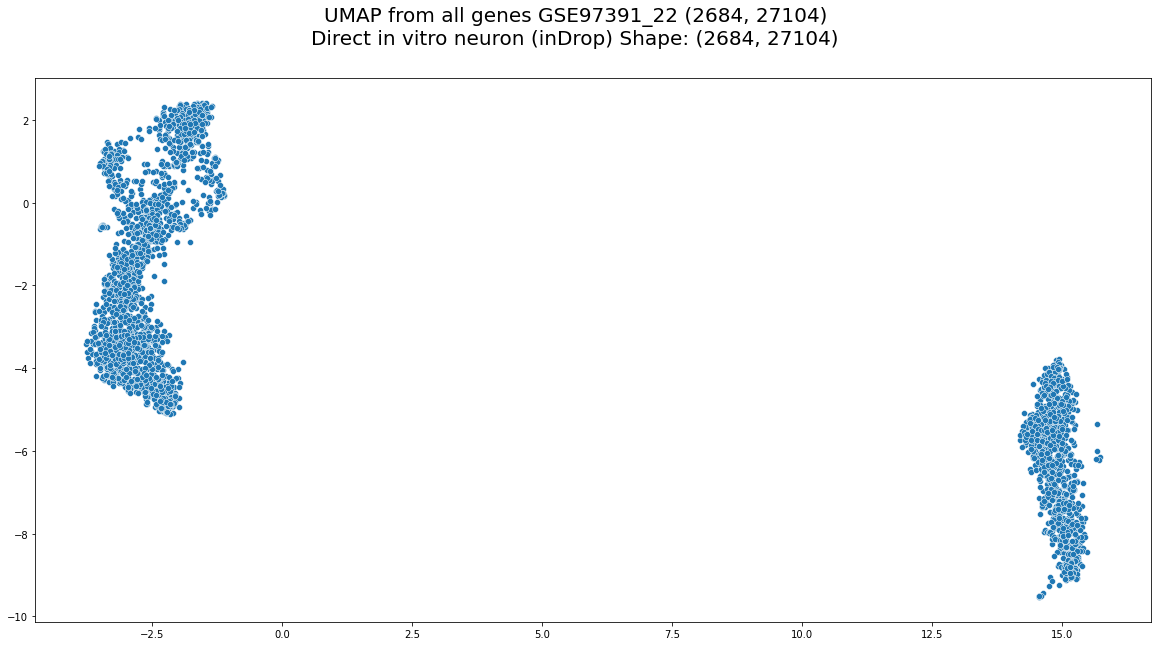

Total  124.6 seconds passed


In [ ]:
import time,umap
t0 = time.time()
# fn='single_cell/GSE67123_6.h5ad'
# adata1 = sc.read(fn) # sc.read_h5ad
# str_data_inf_1 = fn.split('/')[1].split('.')[0] + ' ' + str(adata1.X.shape)+'\n' + adata1.uns['info'][0]

# reducer = umap.UMAP()
# r = reducer.fit_transform(adata1.X)

# fig = plt.figure(figsize = (20,10)); c = 0
# plt.suptitle('UMAP from all genes ' +str_data_inf_1 + ' Shape: ' + str(adata1.X.shape) , fontsize = 20  )
# sns.scatterplot(x = r[:,0], y = r[:,1]  , hue = adata1.uns['Phenotype'])
# plt.show()

fn='single_cell/GSE74767_2.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad
str_data_inf_2 = fn.split('/')[1].split('.')[0] + ' ' + str(adata2.X.shape)+'\n' + adata2.uns['info'][0]

reducer = umap.UMAP(n_components=2)
r = reducer.fit_transform(adata2.X)

fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from all genes ' +str_data_inf_2 + ' Shape: ' + str(adata2.X.shape) , fontsize = 20  )
sns.scatterplot(x = r[:,0], y = r[:,1]  , hue = adata2.uns['Phenotype'])
plt.show()

# fn='single_cell/GSE97391_27.h5ad'
# adata3 = sc.read(fn) # sc.read_h5ad
# str_data_inf_3 = fn.split('/')[1].split('.')[0] + ' ' + str(adata3.X.shape)+'\n' + adata3.uns['info'][0]

# reducer = umap.UMAP(n_components=2)
# r = reducer.fit_transform(adata3.X)

# fig = plt.figure(figsize = (20,10)); c = 0
# plt.suptitle('UMAP from all genes ' +str_data_inf_3 + ' Shape: ' + str(adata3.X.shape) , fontsize = 20  )
# sns.scatterplot(x = r[:,0], y = r[:,1]  , hue = adata3.uns['Phenotype'])
# plt.show()

fn='single_cell/GSE98664_20.h5ad'
adata4 = sc.read(fn) # sc.read_h5ad
str_data_inf_4 = fn.split('/')[1].split('.')[0] + ' ' + str(adata4.X.shape)+'\n' + adata4.uns['info'][0]

reducer = umap.UMAP(n_components=2)
r = reducer.fit_transform(adata4.X)

fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from all genes ' +str_data_inf_4 + ' Shape: ' + str(adata4.X.shape) , fontsize = 20  )
sns.scatterplot(x = r[:,0], y = r[:,1]  , hue = adata4.uns['Phenotype'])
plt.show()

fn='single_cell/GSE97391_22.h5ad'
adata5 = sc.read(fn) # sc.read_h5ad
str_data_inf_5 = fn.split('/')[1].split('.')[0] + ' ' + str(adata5.X.shape)+'\n' + adata5.uns['info'][0]

reducer = umap.UMAP(n_components=2)
r = reducer.fit_transform(adata5.X)

fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from all genes ' +str_data_inf_5 + ' Shape: ' + str(adata5.X.shape) , fontsize = 20  )
sns.scatterplot(x = r[:,0], y = r[:,1]  , hue = adata5.uns['Phenotype'])
plt.show()


print('Total ', np.round(time.time() - t0,1), 'seconds passed')


In [ ]:
# S_phase_genes_Tirosh = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
# G2_M_genes_Tirosh = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
# u = 'allgenenames'    
# list_genes_upper = [t.upper() for t in adata.uns[u] ]
# I = np.where( pd.Series(list_genes_upper).isin( S_phase_genes_Tirosh + G2_M_genes_Tirosh ) )[0]

In [ ]:
t0 = time.time()
# AA=pd.DataFrame(adata1.X,columns=adata1.uns['gcsGenesNames'],index=adata1.uns['allcellnames'])
# g1=graphistry.nodes(AA.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

# BB=pd.DataFrame(adata2.X,columns=adata2.uns['gcsGenesNames'],index=adata2.uns['allcellnames'])
# g2=graphistry.nodes(BB.reset_index(),"index")#,columns=adata2.uns['gcsGenesNames']))

# CC=pd.DataFrame(adata3.X,columns=adata3.uns['gcsGenesNames'],index=adata3.uns['allcellnames'])
# g3=graphistry.nodes(CC.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

DD=pd.DataFrame(adata4.X,columns=adata4.uns['gcsGenesNames'],index=adata4.uns['allcellnames'])
g4=graphistry.nodes(DD.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

EE=pd.DataFrame(adata5.X,columns=adata5.uns['gcsGenesNames'],index=adata5.uns['allcellnames'])
g5=graphistry.nodes(EE.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))


# g11 = g1.umap(
#             use_scaler='robust', ## zscale, minmax, standard, normal,
#             n_components=2,
#             n_neighbors=12
#     )

# g22 = g2.umap(
#             use_scaler='robust', ## zscale, minmax, standard, normal,
#             n_components=2,
#             n_neighbors=12
#     )

# g33 = g3.umap(
#             use_scaler='robust', ## zscale, minmax, standard, normal,
#             n_components=2,
#             n_neighbors=12
#     )

g44 = g4.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12
    )

g55 = g5.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  27.1 seconds passed


In [ ]:
# emb1=g11._node_embedding
# emb2=g22._node_embedding
# emb3=g33._node_embedding
emb4=g44._node_embedding
emb5=g55._node_embedding

In [ ]:
# g222=graphistry.nodes(emb2.reset_index(),'index').edges(g22._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
# g222.plot()

In [ ]:
g444=graphistry.nodes(emb4.reset_index(),'index').edges(g44._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g444.plot()

In [ ]:
g555=graphistry.nodes(emb5.reset_index(),'index').edges(g55._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g555.plot()

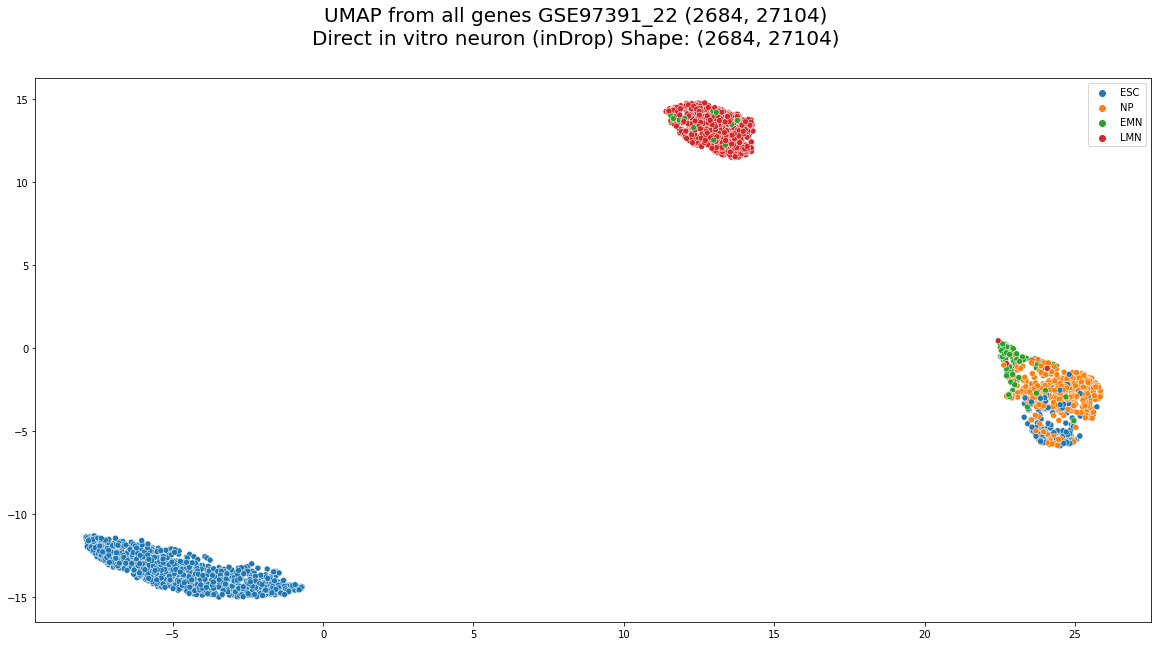

In [ ]:


fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('UMAP from all genes ' +str_data_inf_5 + ' Shape: ' + str(adata5.X.shape) , fontsize = 20  )
sns.scatterplot(x = adata5.uns['X_umap'][:,0], y = adata5.uns['X_umap'][:,1]  , hue = adata5.uns['Phenotype'])
plt.show()

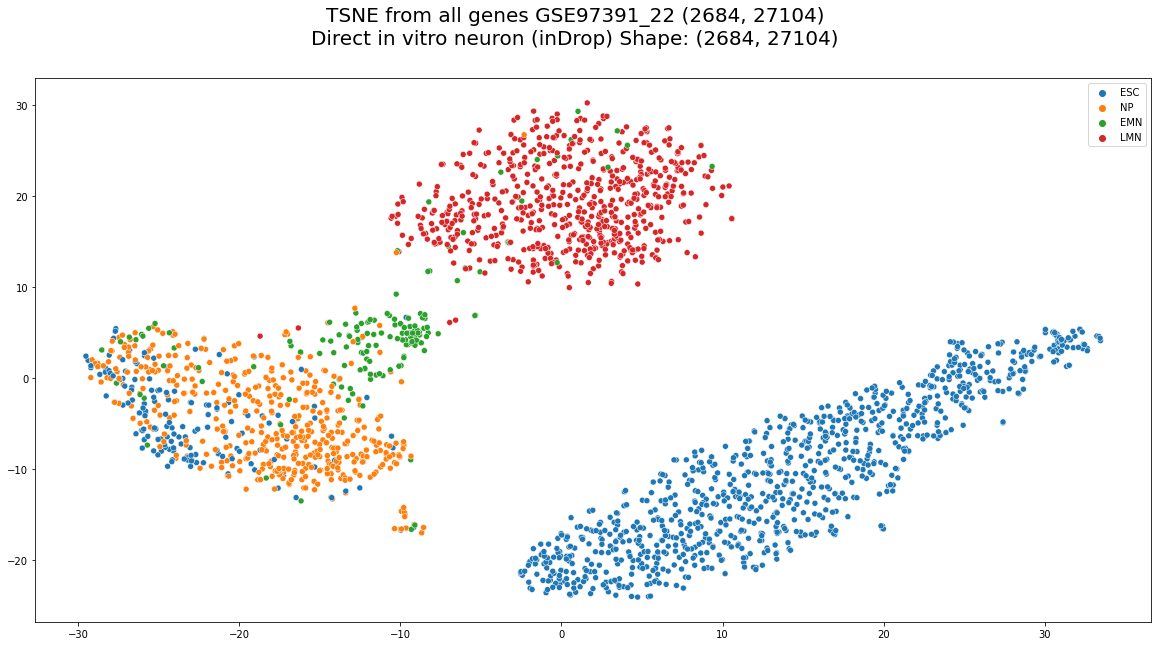

In [ ]:


fig = plt.figure(figsize = (20,10)); c = 0
plt.suptitle('TSNE from all genes ' +str_data_inf_5 + ' Shape: ' + str(adata5.X.shape) , fontsize = 20  )
sns.scatterplot(x = adata5.uns['X_tsne'][:,0], y = adata5.uns['X_tsne'][:,1]  , hue = adata5.uns['Phenotype'])
plt.show()